In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

no_preview = True # Toggle to False to use the preview widget
                  # instead of rendering for scene visualization

from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera,\
                      RadioMapSolver, PathSolver
from sionna.rt.utils import r_hat, subcarrier_frequencies

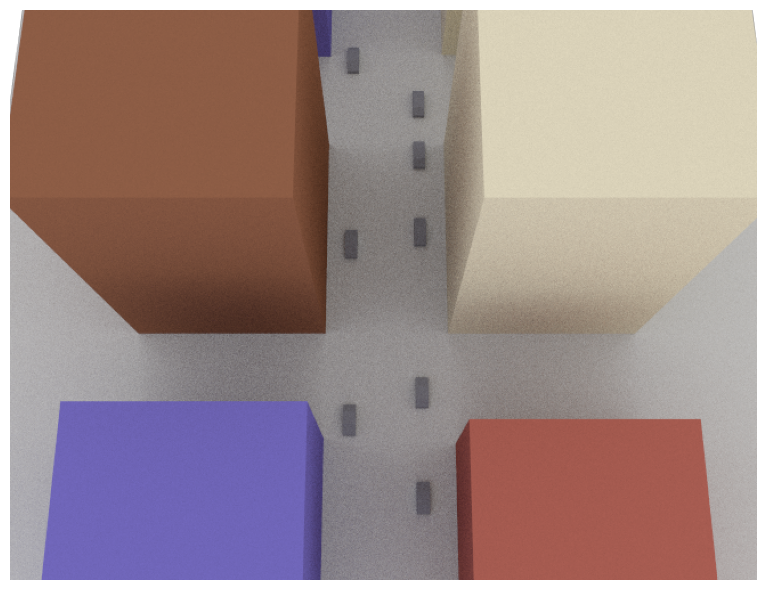

In [2]:
scene = load_scene(sionna.rt.scene.simple_street_canyon_with_cars,
                   merge_shapes=False)
cam = Camera(position=[50,0,130], look_at=[10,0,0])

if no_preview:
    scene.render(camera=cam);
else:
    scene.preview();

In [3]:
scene.objects

{'building_1': <sionna.rt.scene_object.SceneObject at 0x135c50cb0>,
 'building_6': <sionna.rt.scene_object.SceneObject at 0x135c8c9e0>,
 'building_5': <sionna.rt.scene_object.SceneObject at 0x135c8cb00>,
 'building_4': <sionna.rt.scene_object.SceneObject at 0x135c8cbf0>,
 'building_3': <sionna.rt.scene_object.SceneObject at 0x135c8cd10>,
 'building_2': <sionna.rt.scene_object.SceneObject at 0x135c8ce00>,
 'floor': <sionna.rt.scene_object.SceneObject at 0x135c8cef0>,
 'car_3': <sionna.rt.scene_object.SceneObject at 0x135c8cfb0>,
 'car_4': <sionna.rt.scene_object.SceneObject at 0x135c8d100>,
 'car_5': <sionna.rt.scene_object.SceneObject at 0x135c8d220>,
 'car_2': <sionna.rt.scene_object.SceneObject at 0x135c8d310>,
 'car_1': <sionna.rt.scene_object.SceneObject at 0x135c8d400>,
 'car_6': <sionna.rt.scene_object.SceneObject at 0x135c8d4f0>,
 'car_7': <sionna.rt.scene_object.SceneObject at 0x135c8d5e0>,
 'car_8': <sionna.rt.scene_object.SceneObject at 0x135c8d6d0>}

In [4]:
car_2 = scene.get("car_2")
print("Position: ", car_2.position.numpy()[:,0])
print("Orientation: ", car_2.orientation.numpy()[:,0])

Position:  [25.         5.5999994  0.7500001]
Orientation:  [0. 0. 0.]


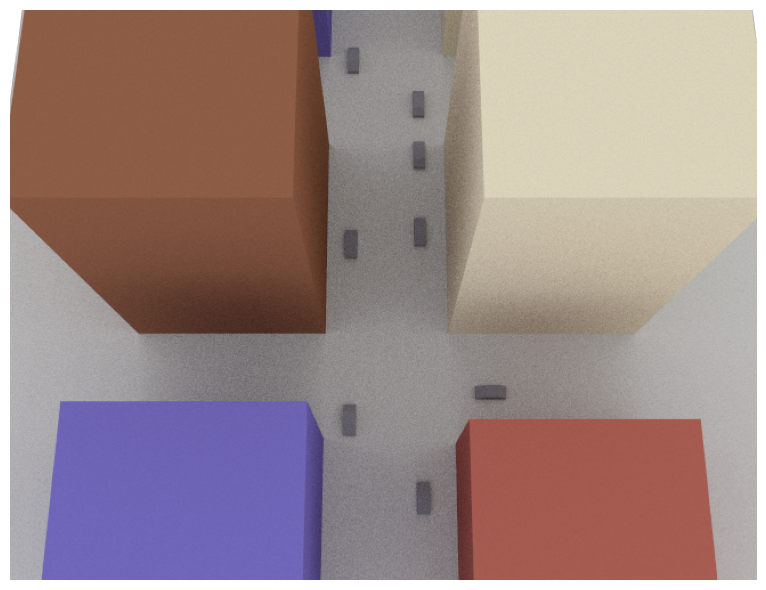

In [5]:
# Move the car 10m along the y-axis
car_2.position += [0, 10, 0]

# And rotate it by 90 degree around the z-axis
car_2.orientation = [np.pi/2, 0, 0]

if no_preview:
    scene.render(camera=cam);
else:
    scene.preview();

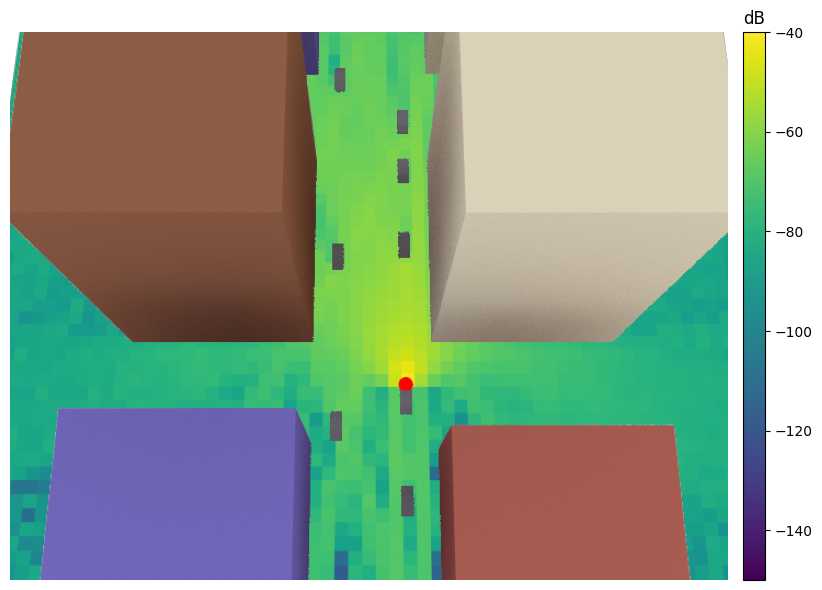

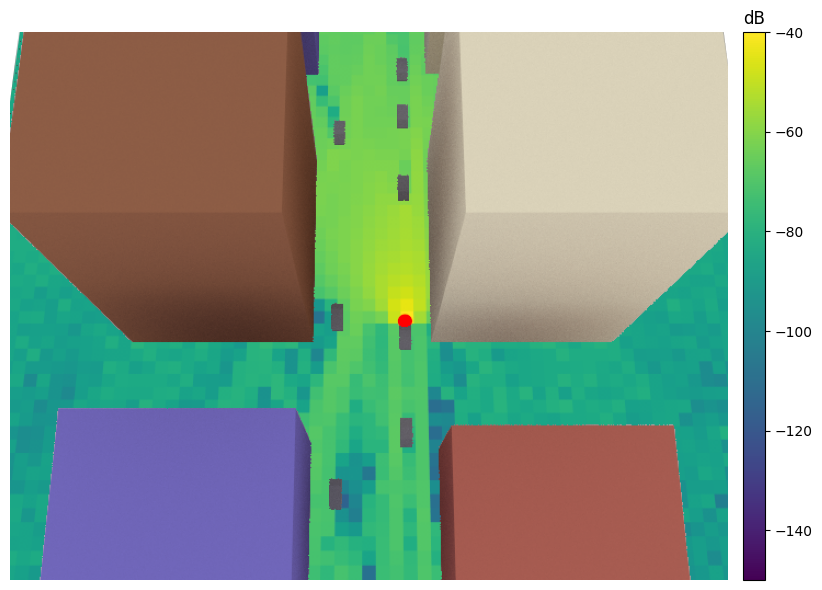

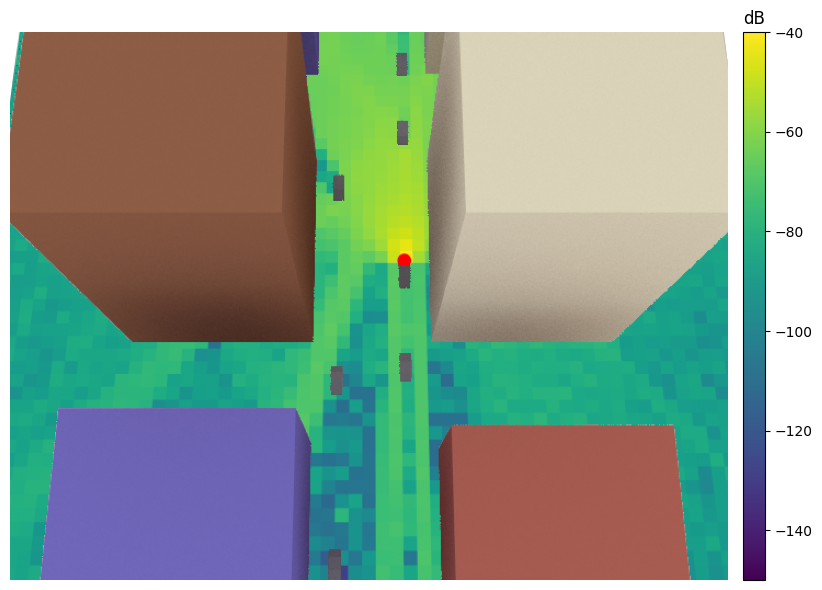

In [7]:
scene = load_scene(sionna.rt.scene.simple_street_canyon_with_cars,
                   merge_shapes=False)
cam =  Camera(position=[50,0,130], look_at=[10,0,0])

# Configure a transmitter that is located at the front of "car_2"
scene.add(Transmitter("tx", position=[22.7, 5.6, 0.75], orientation=[np.pi,0,0]))
scene.tx_array = PlanarArray(num_rows=1, num_cols=1, pattern="tr38901", polarization="V")
scene.rx_array = scene.tx_array

# Create radio map solver
rm_solver = RadioMapSolver()

# Move cars along straight lines for a couple of steps
displacement_vec = [10, 0, 0]
num_displacements = 2
for _ in range(num_displacements+1):

    # Compute and render a coverage map at 0.5m above the ground
    rm = rm_solver(scene=scene,
                   samples_per_tx=20**6,
                   refraction=True,
                   max_depth=10,
                   center=[0,0,0.5],
                   orientation=[0,0,0],
                   size=[186,121],
                   cell_size=[2,2])
    scene.render(camera=cam, radio_map=rm,
                 num_samples=512, rm_show_color_bar=True,
                 rm_vmax=-40, rm_vmin=-150)

    # Move TX to next position
    scene.get("tx").position -= displacement_vec

    # Move cars driving in -x direction
    for j in range(1,6):
        scene.get(f"car_{j}").position -= displacement_vec

    # Move cars driving in x direction
    for j in range(6,9):
        scene.get(f"car_{j}").position += displacement_vec

In [9]:
# Load scene with a single reflector
scene = load_scene(sionna.rt.scene.simple_reflector,
                   merge_shapes=False)
# Inspect the velocity of this object
print("Velocity vector: ", scene.get("reflector").velocity.numpy()[:,0])

# Update velocity vector
scene.get("reflector").velocity = [0, 0, -20]
print("Velocity vector after update: ", scene.get("reflector").velocity.numpy()[:,0])

Velocity vector:  [0. 0. 0.]
Velocity vector after update:  [  0.   0. -20.]


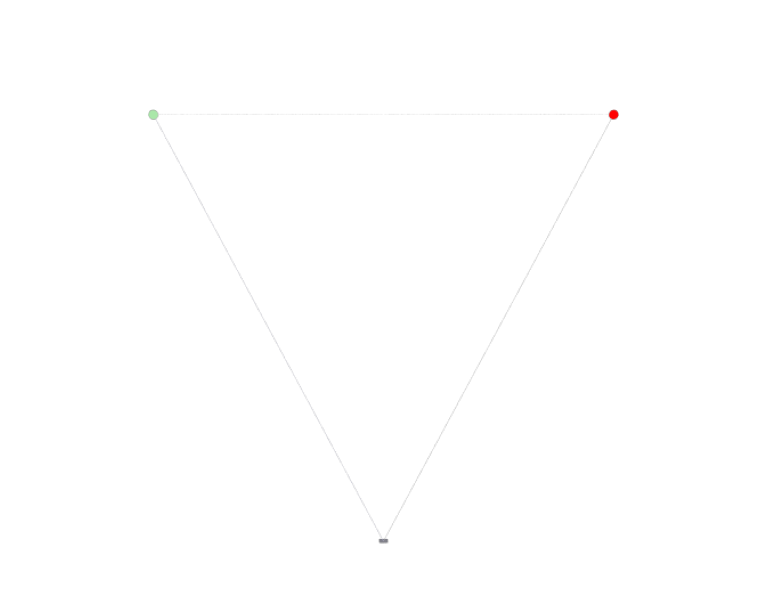

In [10]:
# Configure arrays for all transmitters and receivers in the scene
scene.tx_array = PlanarArray(num_rows=1,num_cols=1,pattern="iso", polarization="V")
scene.rx_array = scene.tx_array

# Add a transmitter and a receiver
scene.add(Transmitter("tx", [-25,0.1,50]))
scene.add(Receiver("rx",    [ 25,0.1,50]))

# Compute paths
p_solver = PathSolver()
paths = p_solver(scene=scene, max_depth=1)

# Visualize the scene and propagation paths
if no_preview:
    cam = Camera(position=[0, 100, 50], look_at=[0,0,30])
    scene.render(camera=cam, paths=paths);
else:
    scene.preview(paths=paths)

In [11]:
print("Path interaction (0=LoS, 1=Specular reflection): ", paths.interactions.numpy())
print("Doppler shifts (Hz): ", paths.doppler.numpy())


Path interaction (0=LoS, 1=Specular reflection):  [[[[0 1]]]]
Doppler shifts (Hz):  [[[   0.      -417.68835]]]


In [12]:
num_ofdm_symbols = 1024
num_subcarriers = 1024
subcarrier_spacing = 30e3

ofdm_symbol_duration = 1/subcarrier_spacing
delay_resolution = ofdm_symbol_duration/num_subcarriers
doppler_resolution = subcarrier_spacing/num_ofdm_symbols

print("Delay   resolution (ns): ", int(delay_resolution/1e-9))
print("Doppler resolution (Hz): ", int(doppler_resolution))

Delay   resolution (ns):  32
Doppler resolution (Hz):  29


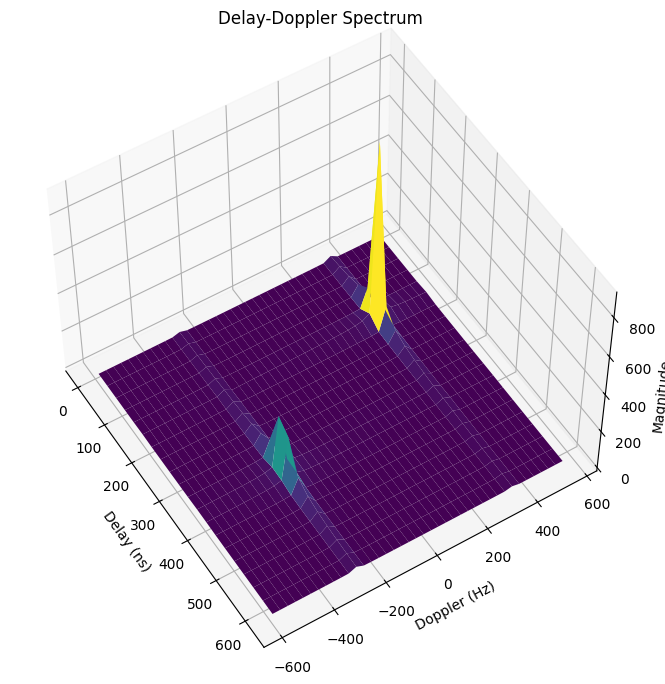

In [13]:
# Set TX velocity
tx_velocity = [30, 0, 0]
scene.get("tx").velocity = tx_velocity

# Recompute the paths
paths = p_solver(scene=scene, max_depth=1, refraction=False)

# Compute channel frequency response with time evolution
frequencies = subcarrier_frequencies(num_subcarriers, subcarrier_spacing)

h = paths.cfr(frequencies=frequencies,
              sampling_frequency=1/ofdm_symbol_duration,
              num_time_steps=num_ofdm_symbols,
              normalize_delays=False, normalize=True, out_type="numpy")


### Compute the Delay-Doppler spectrum

# Squeeze useless dimensions
# [num_time_steps, fft_size]
h = np.squeeze(h)

# Apply an FFTshift to bring subcarriers in the
# correct order for an IFFT
h = np.fft.fftshift(h, axes=1)

# Apply IFFT to subcarrier dimension to
# convert frequency to delay domain
h_delay = np.fft.ifft(h, axis=1, norm="ortho")

# Apply FFT to time-step dimension to
# convert time to Doppler domain
h_delay_doppler = np.fft.fft(h_delay, axis=0, norm="ortho")

# Apply FFTShift to bring Doppler dimension in the correct
# order for visualization
h_delay_doppler = np.fft.fftshift(h_delay_doppler, axes=0)

# Compute meshgrid for visualization of the Delay-Doppler spectrum
doppler_bins = np.arange(-num_ofdm_symbols/2*doppler_resolution,
                          num_ofdm_symbols/2*doppler_resolution,
                         doppler_resolution)

delay_bins = np.arange(0,
                       num_subcarriers*delay_resolution,
                       delay_resolution) / 1e-9

x, y = np.meshgrid(delay_bins, doppler_bins)

# Visualize Delay-Doppler spectrum
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')

# We only visualize the relevant part of the spectrum
offset = 20
x_start = int(num_subcarriers/2)-offset
x_end = int(num_subcarriers/2)+offset
y_start = 0
y_end = offset
x_grid = x[x_start:x_end,y_start:y_end]
y_grid = y[x_start:x_end,y_start:y_end]
z_grid = np.abs(h_delay_doppler[x_start:x_end,y_start:y_end])

surf = ax.plot_surface(x_grid,
                       y_grid,
                       z_grid,
                       cmap='viridis', edgecolor='none')

ax.set_xlabel('Delay (ns)')
ax.set_ylabel('Doppler (Hz)')
ax.set_zlabel('Magnitude');
ax.zaxis.labelpad=2
ax.view_init(elev=53, azim=-32)
ax.set_title("Delay-Doppler Spectrum");

In [14]:
print("Delay - LoS Path (ns) :", paths.tau[0,0,0]/1e-9)
print("Doppler - LoS Path (Hz) :", paths.doppler[0,0,0])

print("Delay - Reflected Path (ns) :", paths.tau[0,0,1].numpy()/1e-9)
print("Doppler - Reflected Path (Hz) :", paths.doppler[0,0,1])

Delay - LoS Path (ns) : 166.782
Doppler - LoS Path (Hz) : 350.242
Delay - Reflected Path (ns) : 372.93597188181593
Doppler - Reflected Path (Hz) : -261.056


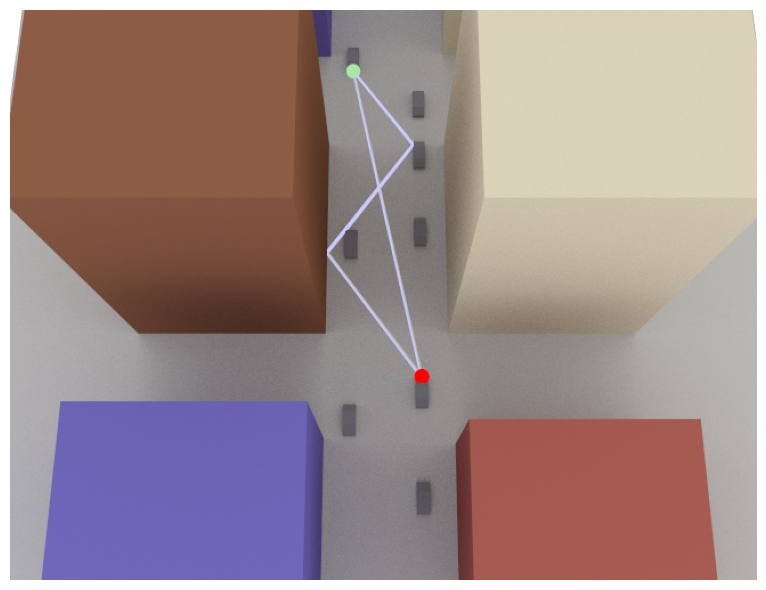

In [15]:
scene = load_scene(sionna.rt.scene.simple_street_canyon_with_cars,
                   merge_shapes=False)
cam = Camera(position=[50,0,130], look_at=[10,0,0])

# Parameters for ray tracing
max_depth = 3
refraction = False # Toggle to true to see the impact of refraction
diffraction = False # Toggle to true to see the impact of diffraction

# TX and RX have directional antennas
scene.tx_array = PlanarArray(num_rows=1, num_cols=1, pattern="tr38901", polarization="V")
scene.rx_array = scene.tx_array

# TX and RX are installed at the front of two different cars.
# The directive antennas ensure that paths reaching an antenna from the back are close to zero.
scene.add(Transmitter("tx", position=[22.7, 5.6, 0.75], orientation=[np.pi,0,0]))
scene.add(Receiver("rx", position=[-27.8,-4.9, 0.75]))

# Configure an OFDM resource grid
num_ofdm_symbols = 25
num_subcarriers = 1024
subcarrier_spacing = 30e3
frequencies = subcarrier_frequencies(num_subcarriers, subcarrier_spacing)
ofdm_symbol_duration = 1/subcarrier_spacing

# Define a velocity vector and the corresponding displacement over the duration
# of one OFDM symbol
velocity_vec = np.array([10,0,0])
displacement_vec = velocity_vec*ofdm_symbol_duration

# Assign velocity vector to cars driving in -x direction
for j in range(1,6):
    scene.get(f"car_{j}").velocity = -velocity_vec

# Assign velocity vector to cars driving in x direction
for j in range(6,9):
    scene.get(f"car_{j}").velocity = velocity_vec

# Compute paths
scene.get("tx").velocity = -velocity_vec
scene.get("rx").velocity = velocity_vec

paths = p_solver(scene=scene, max_depth=max_depth, refraction=refraction, diffraction=diffraction)

# Compute the corresponding channel frequency responses with time evolution
h_dop = paths.cfr(frequencies=frequencies,
              sampling_frequency=1/ofdm_symbol_duration,
              num_time_steps=num_ofdm_symbols,
              normalize_delays=False, out_type="numpy")
h_dop = np.squeeze(h_dop)


# Visualize the scene and propagation paths
if no_preview:
    scene.render(camera=cam, paths=paths, num_samples=512);
else:
    scene.preview(paths=paths)


In [16]:
paths = p_solver(scene=scene, max_depth=max_depth, refraction=refraction, diffraction=diffraction)
h_sim = np.squeeze(paths.cfr(frequencies=frequencies,
              sampling_frequency=1/ofdm_symbol_duration,
              normalize_delays=False, out_type="numpy"), axis=(0,1,2,3))

for i in range(num_ofdm_symbols-1):
    # Move TX and RX to next position
    scene.get("tx").position -= displacement_vec
    scene.get("rx").position += displacement_vec

    # Move cars driving in -x direction to the next position
    for j in range(1,6):
        scene.get(f"car_{j}").position -= displacement_vec

    # Move cars driving in +x direction to the next position
    for j in range(6,9):
        scene.get(f"car_{j}").position += displacement_vec

    # Compute channel frequency response
    paths = p_solver(scene=scene, max_depth=max_depth, refraction=refraction, diffraction=diffraction)
    h = np.squeeze(paths.cfr(frequencies=frequencies,
              sampling_frequency=1/ofdm_symbol_duration,
              normalize_delays=False, out_type="numpy"), axis=(0,1,2,3))

    # Concatenate along the time dimensions
    h_sim = np.concatenate([h_sim, h], axis=0)

In [17]:
paths = p_solver(scene=scene, max_depth=max_depth, refraction=refraction, diffraction=diffraction)
h_sim = np.squeeze(paths.cfr(frequencies=frequencies,
              sampling_frequency=1/ofdm_symbol_duration,
              normalize_delays=False, out_type="numpy"), axis=(0,1,2,3))

for i in range(num_ofdm_symbols-1):
    # Move TX and RX to next position
    scene.get("tx").position -= displacement_vec
    scene.get("rx").position += displacement_vec

    # Move cars driving in -x direction to the next position
    for j in range(1,6):
        scene.get(f"car_{j}").position -= displacement_vec

    # Move cars driving in +x direction to the next position
    for j in range(6,9):
        scene.get(f"car_{j}").position += displacement_vec

    # Compute channel frequency response
    paths = p_solver(scene=scene, max_depth=max_depth, refraction=refraction, diffraction=diffraction)
    h = np.squeeze(paths.cfr(frequencies=frequencies,
              sampling_frequency=1/ofdm_symbol_duration,
              normalize_delays=False, out_type="numpy"), axis=(0,1,2,3))

    # Concatenate along the time dimensions
    h_sim = np.concatenate([h_sim, h], axis=0)